In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from utils import *
from scipy.fft import fft
import os
from jax import random
from jax.experimental.optimizers import adam, sgd
from jax import numpy as jnp
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
from functools import partial

from utils import Shuffler


In [2]:
def add_derivatives(df, cols = ["x", "y", "fx", "fy"]):
    dt = (df["datetime"] - df["datetime"].shift()).median().delta*1e-9
    for col in cols:
        df = append_derivatives_to_dataframe(df, col, dt=dt, window_length=31, polyorder=3)
    return df

def read_txt(file):
    df = pd.read_csv(file, sep="\t", header=None)

    file_break_indexes = list(df[df[0]=="waveform"].index) + [df.index.max()]

    files = []
    for i in range(len(file_break_indexes) - 1):
        file = df.loc[file_break_indexes[i]:file_break_indexes[i+1]]
        file.columns = file.iloc[0]
        file = file.drop(file.index[0])
        file = file.iloc[:-1].dropna(how="all")
        files.append(file)
    return files



file = "../amb_other/sweep_fx_4to69Hz_1seg_0RPM.txt"
files = read_txt(file)
file = "../amb_other/sweep_fy_4to69Hz_1seg_0RPM.txt"
files.extend(read_txt(file))
print(len(files))

dfs = []
for df in files:    
    df = df.iloc[3:]
    old_cols = ["waveform", "Pos_Ax [um]", "Pos_Ay [um]", "Pos_Bx [um]", "Pos_By [um]", "F_Ax [N]",
                "F_Ay [N]", "F_Bx [N]", "F_By [N]", "Ex_Ax", "Ex_Ay", 'Ex_Bx', "Ex_By"]
    new_cols = ["datetime", "ax", "ay", "bx", "by", "f_ax", "f_ay", "f_bx", "f_by", "e_ax", "e_ay", "e_bx", "e_by"]
    df = df[old_cols]
    df.rename(columns = dict(zip(old_cols, new_cols)), inplace=True)
    df["datetime"] = df["datetime"].apply(pd.to_datetime)

    def to_float(x):
        if not isinstance(x, str):
            return x
        return float(x.replace(",", "."))

    for col in [ "ax", "ay", "bx", "by", "f_ax", "f_ay", "f_bx", "f_by", "e_ax", "e_ay", "e_bx", "e_by"]:
        df[col] = df[col].apply(to_float)

    
    df = df.drop(df[pd.isnull(df["datetime"])].index)
    df["f_ay"] -= df["f_ay"].mean()
    df["f_ax"] -= df["f_ax"].mean()
    df["f_bx"] -= df["f_bx"].mean()
    df["f_by"] -= df["f_by"].mean()
    df["x"] = (df["ax"] + df["bx"])/2
    #df["x"] = df["ax"]
    df["y"] = (df["ay"] + df["by"])/2
    #df["y"] = df["ay"]
    df['fx'] = df["f_ax"] + df["f_bx"]
    #df["fx"] = df["f_ax"]
    df['fy'] = df["f_ay"] + df["f_by"]
    #df["fx"] = df["f_ay"]
    df = df[["datetime", "x", "y", "fx", "fy"]]

    
    
    dfs.append(df)

    



dfs = list(map(add_derivatives, dfs))

4


In [3]:
dfs[-1]

,datetime,x,y,fx,fy,x_dot,x_dot2,y_dot,y_dot2,fx_dot,fx_dot2,fy_dot,fy_dot2
4,2019-03-24 02:02:19.426152,-0.000010,0.000021,0.065548,-0.889093,-0.001762,1.287175,-0.005557,-1.382982,313.028198,-202835.720712,-258.920127,276987.921532
5,2019-03-24 02:02:19.426348,-0.000010,0.000020,0.122708,-0.917256,-0.001517,1.229091,-0.005821,-1.321676,274.535282,-191963.420658,-206.278818,262922.939499
6,2019-03-24 02:02:19.426543,-0.000011,0.000018,0.172570,-0.939445,-0.001283,1.171006,-0.006073,-1.260370,238.162464,-181091.120603,-156.380180,248857.957467
7,2019-03-24 02:02:19.426738,-0.000011,0.000017,0.215546,-0.955830,-0.001060,1.112922,-0.006312,-1.199064,203.909744,-170218.820548,-109.224215,234792.975434
8,2019-03-24 02:02:19.426934,-0.000011,0.000016,0.252049,-0.966577,-0.000849,1.054838,-0.006540,-1.137759,171.777124,-159346.520493,-64.810920,220727.993402
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66570,2019-03-24 02:02:32.425176,-0.000013,0.000031,0.256923,-1.046685,0.000552,0.564408,-0.010476,-1.773871,-4.919702,82178.993448,274.220131,180055.469935
66571,2019-03-24 02:02:32.425371,-0.000013,0.000029,0.261158,-0.987466,0.000666,0.602163,-0.010827,-1.817639,11.986757,91220.579612,310.418923,191214.186494
66572,2019-03-24 02:02:32.425566,-0.000013,0.000027,0.270881,-0.919662,0.000787,0.639919,-0.011185,-1.861408,30.656324,100262.165777,348.793664,202372.903054
66573,2019-03-24 02:02:32.425762,-0.000013,0.000025,0.286646,-0.842709,0.000915,0.677674,-0.011553,-1.905176,51.089001,109303.751942,389.344355,213531.619614


In [5]:
t = (df["datetime"] - df["datetime"].iloc[0]).apply(lambda x: x.delta*1e-9)
t_div = t.apply(lambda x: x//1)

(3950.0, 5000.0)

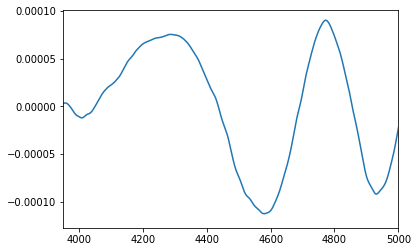

In [19]:
plt.plot(dfs[0]["x"])
plt.xlim((3950, 5000))

In [43]:
_df = dfs[0]
#df = df.iloc[4000:4*(4000 + int(1/0.000195))]

_df = _df.iloc[3950:]
t = (_df["datetime"] - _df["datetime"].iloc[0]).apply(lambda x: x.delta*1e-9)
t_div = t.apply(lambda x: x//1)

params_history = []
for section in t_div.unique():
    
    
    df = _df.loc[t_div[t_div==section].index]
    mass = 1
    window = 320
    df["fx_"] = df["fx"] - mass*df["x_dot2"]
    df["fy_"] = df["fy"] - mass*df["y_dot2"]
    _params_history = []
    for i in tqdm(range(df.shape[0] - window)):
        X = df[["x_dot", "y_dot", "x", "y"]].values[i:(i+window)]

        Y = df[["fx_", "fy_"]].values[i:(i+window)]
        params = np.linalg.inv( X.transpose() @ X ) @ X.transpose() @ Y
        _params_history.append(params)
        
    params_history.append(_params_history)

params_history_x = np.array(params_history)


100%|██████████| 850/850 [00:01<00:00, 713.50it/s]
<ipython-input-43-947d51bd2e09>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_history_x = np.array(params_history)


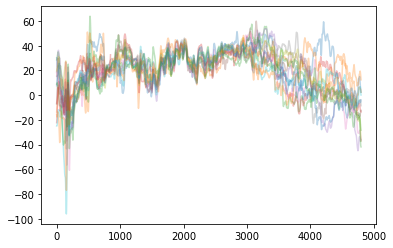

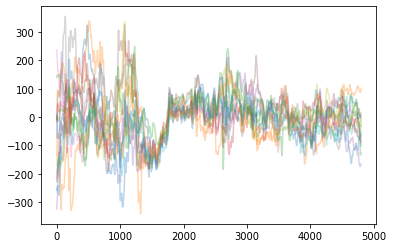

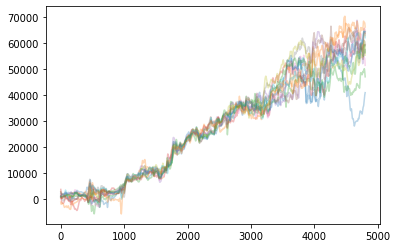

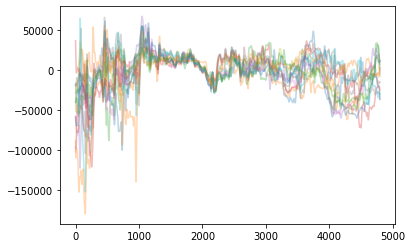

In [44]:
#plt.plot(params_history_x[:, :, 0, 0].transpose())
for i in range(4):
    for section in params_history_x:
        section = np.array(section)[:, i, 0]
        plt.plot(section, alpha=0.3)
    plt.show()

In [45]:
for i in params_history_x:
    print(np.array(i).shape)

(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(850, 4, 2)


In [46]:
params_history_x = params_history_x[:-1]

In [47]:
params_history_x = np.array(params_history_x)
params_history_x = np.array(list(map(np.array, params_history_x))).squeeze()

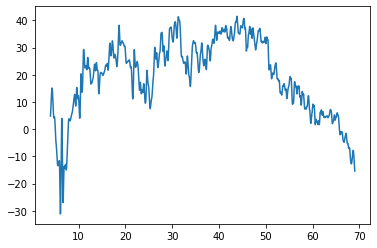

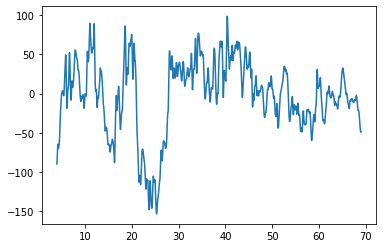

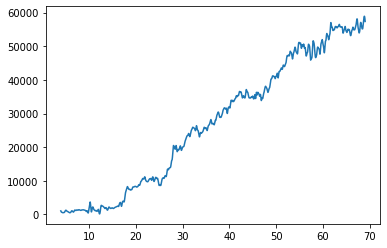

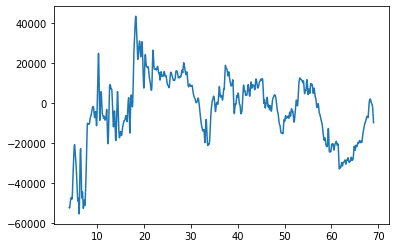

In [61]:
params_history = params_history_x[:, :, :, 0]
params_history = np.mean(params_history, axis=0)
x = np.linspace(4, 69, params_history.shape[0])
for i in range(params_history.shape[1]):
    plt.plot(x, params_history[:,i])
    plt.show()

In [52]:
params_history.shape

(4800, 4)

(3950.0, 5000.0)

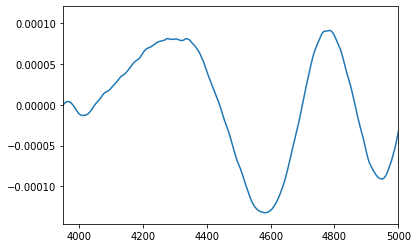

In [65]:
plt.plot(dfs[-1]["y"])
plt.xlim((3950, 5000))

In [67]:
_df = dfs[-1]
#df = df.iloc[4000:4*(4000 + int(1/0.000195))]

_df = _df.iloc[3950:]
t = (_df["datetime"] - _df["datetime"].iloc[0]).apply(lambda x: x.delta*1e-9)
t_div = t.apply(lambda x: x//1)

params_history = []
for section in t_div.unique():
    
    
    df = _df.loc[t_div[t_div==section].index]
    mass = 1
    window = 320
    df["fx_"] = df["fx"] - mass*df["x_dot2"]
    df["fy_"] = df["fy"] - mass*df["y_dot2"]
    _params_history = []
    for i in tqdm(range(df.shape[0] - window)):
        X = df[["x_dot", "y_dot", "x", "y"]].values[i:(i+window)]

        Y = df[["fx_", "fy_"]].values[i:(i+window)]
        params = np.linalg.inv( X.transpose() @ X ) @ X.transpose() @ Y
        _params_history.append(params)
        
    params_history.append(_params_history)

params_history_y = np.array(params_history)


100%|██████████| 850/850 [00:01<00:00, 735.60it/s]
<ipython-input-67-5cc47800d41f>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_history_y = np.array(params_history)


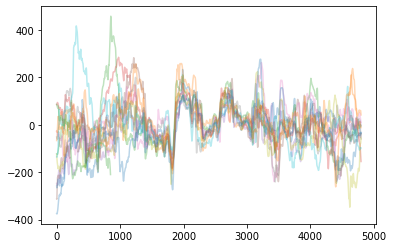

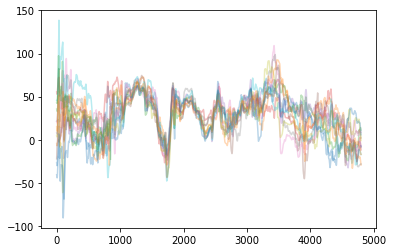

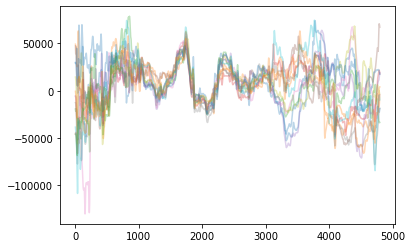

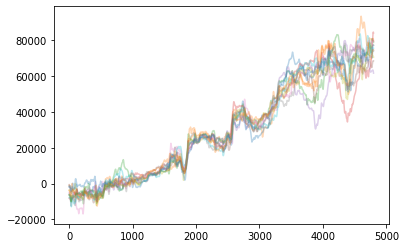

In [68]:
#plt.plot(params_history_x[:, :, 0, 0].transpose())
for i in range(4):
    for section in params_history_y:
        section = np.array(section)[:, i, 1]
        plt.plot(section, alpha=0.3)
    plt.show()

In [71]:
for i in params_history_y:
    print(np.array(i).shape)

(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(4800, 4, 2)
(850, 4, 2)


In [72]:
params_history_y = params_history_y[:-1]

In [73]:
params_history_y = np.array(params_history_y)
params_history_y = np.array(list(map(np.array, params_history_y))).squeeze()

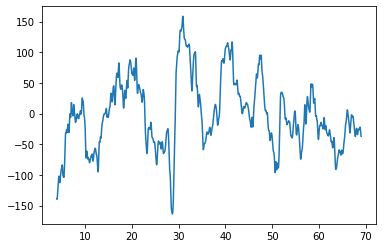

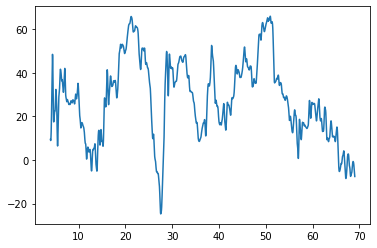

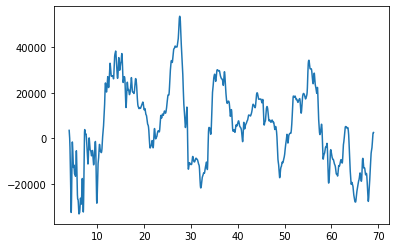

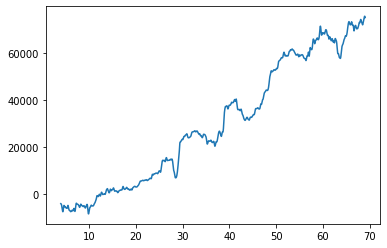

In [75]:
params_history = params_history_y[:, :, :, 1]
params_history = np.mean(params_history, axis=0)
x = np.linspace(4, 69, params_history.shape[0])
for i in range(params_history.shape[1]):
    plt.plot(x, params_history[:,i])
    plt.show()

# Tentando unir os dados em x e y para ver se melhora o resultado

In [ ]:
dfs[0]

In [88]:
_df_x = dfs[0]
_df_y = dfs[-1]
#df = df.iloc[4000:4*(4000 + int(1/0.000195))]

_df_x = _df_x.iloc[3950:]
_df_y = _df_y.iloc[3950:]

t = (_df_x["datetime"] - _df_x["datetime"].iloc[0]).apply(lambda x: x.delta*1e-9)
t_div = t.apply(lambda x: x//1)

params_history = []
for section in t_div.unique():
    
    try:
        df_x = _df_x.loc[t_div[t_div==section].index]
        df_y = _df_y.loc[t_div[t_div==section].index]

        mass = 1
        window = 320

        df_x["fx_"] = df_x["fx"] - mass*df_x["x_dot2"]
        df_x["fy_"] = df_x["fy"] - mass*df_x["y_dot2"]
        df_y["fx_"] = df_y["fx"] - mass*df_y["x_dot2"]
        df_y["fy_"] = df_y["fy"] - mass*df_y["y_dot2"]

        _params_history = []
        for i in tqdm(range(df_x.shape[0] - window)):
            X_x = df_x[["x_dot", "y_dot", "x", "y"]].values[i:(i+window)]
            X_y = df_y[["x_dot", "y_dot", "x", "y"]].values[i:(i+window)]

            Y_x = df_x[["fx_", "fy_"]].values[i:(i+window)]
            Y_y = df_y[["fx_", "fy_"]].values[i:(i+window)]

            X = np.concatenate([X_x, X_y], axis=0)
            Y = np.concatenate([Y_x, Y_y], axis=0)

            params = np.linalg.inv( X.transpose() @ X ) @ X.transpose() @ Y
            _params_history.append(params)

        params_history.append(_params_history)
    except:
        pass
    
params_history_all = np.array(params_history)


100%|██████████| 4800/4800 [00:12<00:00, 373.06it/s]


In [96]:
params_history = np.array(params_history_all)

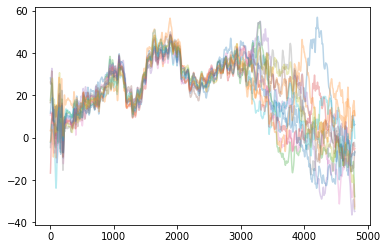

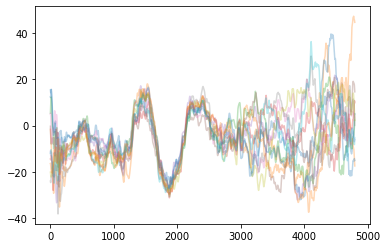

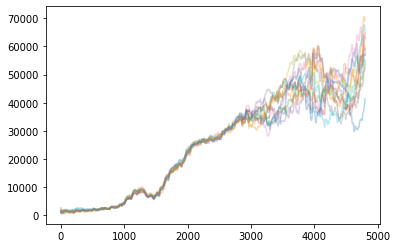

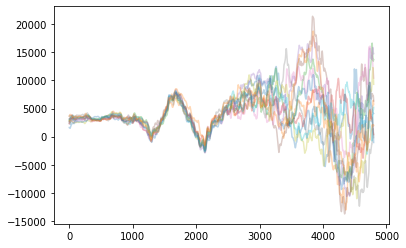

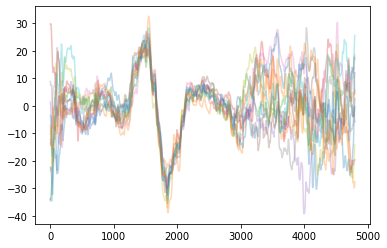

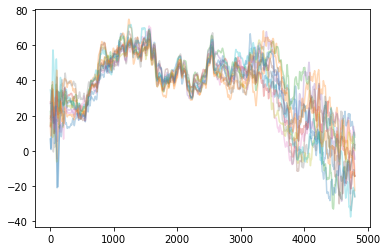

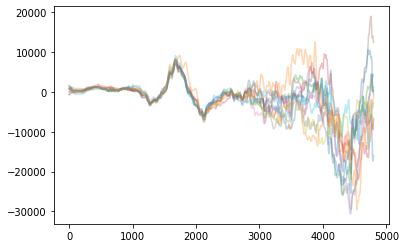

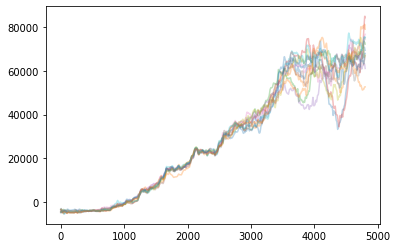

In [97]:
#plt.plot(params_history_x[:, :, 0, 0].transpose())

for i in range(4):
    for section in params_history:
        section = np.array(section)[:, i, 0]
        plt.plot(section, alpha=0.3)
    plt.show()
    
for i in range(4):
    for section in params_history:
        section = np.array(section)[:, i, 1]
        plt.plot(section, alpha=0.3)
    plt.show()

In [98]:
params_history.shape

(12, 4800, 4, 2)

In [99]:
params_history = np.median(params_history, axis=0)

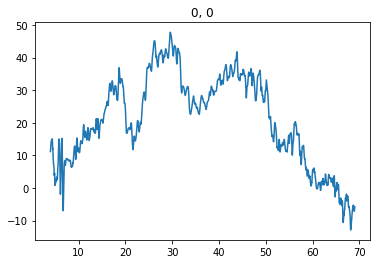

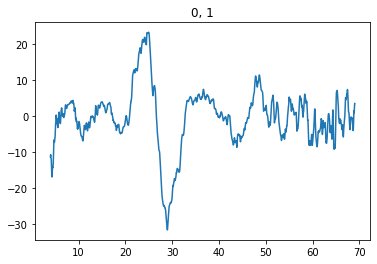

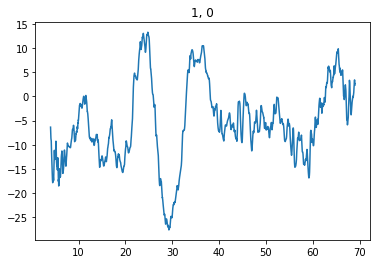

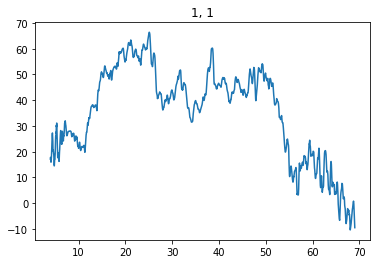

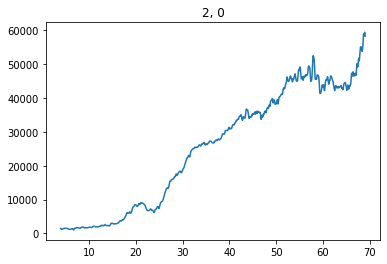

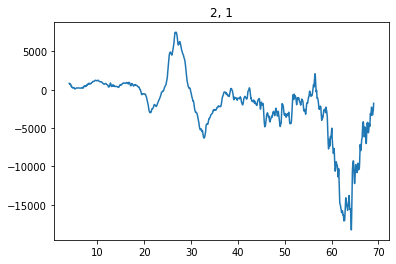

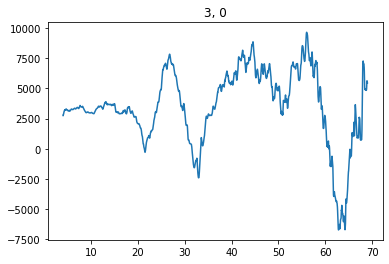

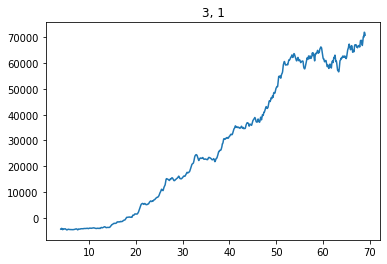

In [100]:

x = np.linspace(4, 69, params_history.shape[0])
for i in range(params_history.shape[1]):
    for j in range(params_history.shape[2]):
        plt.plot(x, params_history[:,i, j])
        plt.title(f"{i}, {j}")
        plt.show()

In [109]:
F = np.linspace(4, 69, params_history.shape[0])
C = params_history[:, :2,]
K = params_history[:, 2:,]


sweep_results_lin_reg = {"freq" : F,
                         "C" : C,
                         "K" : K}

In [111]:
import pickle
with open("../notebooks/results/linreg_sweep_results.pickle", "wb") as f:
    pickle.dump(sweep_results_lin_reg, f)